# Tutorial 4: Pipeline debugging and benchmarking
___
When creating your own end-to-end deep learning workflow, things may go wrong anywhere along the way. You've probably experienced it... That's why it's very important to __access the data after the pipeline__ and examine the correctness of pipeline operations and preprocessing. Furthermore, in some cases, the pipeline may be too slow to keep the GPU busy. Users may need to __benchmark the pipeline speed__ to decide whether to move some operations to GPU or not.

In this tutorial, we are going to show you how to access pipeline results and do pipeline benchmarking. We will use the same pipeline as in tutorial 3.

In [ ]:
import fastestimator as fe
import numpy as np
import os
import tensorflow as tf

## 1) Define the pipeline *(same as tutorial 3)*

In [ ]:
from fastestimator.dataset.mnist import load_data
from fastestimator.op import NumpyOp
from fastestimator.util import RecordWriter
from fastestimator.op.numpyop import ImageReader
from fastestimator.op.tensorop import Augmentation2D
from fastestimator.op import TensorOp

# Create Rescale and Resize custom ops
class Rescale(NumpyOp):
    def forward(self, data, state):
        data = (data - 127.5) / 127.5
        return data

class Resize(TensorOp):
    def __init__(self, inputs, outputs, size):
        super().__init__(inputs=inputs, outputs=outputs)
        self.size = size
    
    def forward(self, data, state):
        data = tf.image.resize(data, self.size)
        return data

# Load data
train_csv, eval_csv, data_path = load_data()

print("image data is generated in {}".format(data_path))

# Create RecordWriter
writer = RecordWriter(save_dir=os.path.join(data_path, "tfrecords"),
                         train_data=train_csv,
                         validation_data=eval_csv,
                         ops=[ImageReader(inputs="x", parent_path=data_path, grey_scale=True), 
                              Rescale(outputs="x")])
# Create Pipeline
pipeline = fe.Pipeline(data=writer,
                       batch_size=32,
                       ops=[Resize(inputs="x", size=(30, 30), outputs="x"),
                            Augmentation2D(outputs="x", mode="train", rotation_range=15)])

## 2) Access the pipeline results

`pipeline.show_results` is built for accessing the pipeline data.  
For example, if users want to access single batch of pipeline data on epoch 0 during training:

In [ ]:
# Use show_results by specifying the epoch, mode and step (batch)
result = pipeline.show_results(current_epoch=0, mode="train", num_steps=1)

# Isolate x and y from result
x = result[0]["x"]
y = result[0]["y"]
print("shape of feature x is {}".format(x.shape))
print("shape of feature y is {}".format(y.shape))

ground truth label is 2
ground truth label is 2
ground truth label is 5
ground truth label is 2


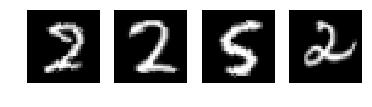

In [4]:
import matplotlib.pyplot as plt

#  Display 4 examples of data after Pipeline
fig, axes = plt.subplots(1, 4)
for i in range(4):
    axes[i].axis('off')
    axes[i].imshow(np.squeeze(x[i]), cmap='gray')
    print("ground truth label is {}".format(y[i]))

## 3) Benchmark pipeline speed

`pipeline.benchmark` can be used to benchmark the pipeline speed.  
For example, if users want to benchmark on epoch 0 during training for 1500 steps (batches):

In [ ]:
# You just have to specify the epoch, mode, and number of batches
pipeline.benchmark(current_epoch=0,mode="train", num_steps=1500)